#### Look at feature importance separately.

#### Imports/setup

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', 60)

from timeit import default_timer as timer

In [3]:
from sklearn.metrics import f1_score, accuracy_score, classification_report

import python.flat_to_labels as ftl

In [16]:
from python.dd_mmll import multi_multi_log_loss, BOX_PLOTS_COLUMN_INDICES
BPCI = BOX_PLOTS_COLUMN_INDICES

In [7]:
from python.multilabel import multilabel_train_test_split

In [6]:
# for the pipeline
from sklearn.pipeline import Pipeline
# for the selectors
from sklearn.preprocessing import FunctionTransformer, StandardScaler, MaxAbsScaler
# for gluing preprocessed text and numbers together
from sklearn.pipeline import FeatureUnion
# for nans in the numeric data
from sklearn.preprocessing import Imputer

In [5]:
# Import classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier

# Import CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# feature selection
from sklearn.feature_selection import SelectFromModel

#### Load the data

In [8]:
# Get data
df = pd.read_csv('data/TrainingData.csv', index_col=0)

In [9]:
# take a look
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
134338,Teacher Compensation,Instruction,School Reported,School,NO_LABEL,Teacher,NO_LABEL,NO_LABEL,PreK-12 Operating,NaN,NaN,NaN,Teacher-Elementary,NaN,NaN,NaN,NaN,1.0,NaN,NaN,KINDERGARTEN,50471.810,KINDERGARTEN,General Fund,NaN
206341,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,CONTRACTOR SERVICES,BOND EXPENDITURES,BUILDING FUND,(blank),Regular,NaN,NaN,NaN,NaN,RGN GOB,NaN,UNDESIGNATED,3477.860,BUILDING IMPROVEMENT SERVICES,NaN,BUILDING IMPROVEMENT SERVICES
326408,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 2ND GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,62237.130,Instruction - Regular,General Purpose School,NaN
364634,Substitute Compensation,Instruction,School Reported,School,Unspecified,Substitute,Benefits,NO_LABEL,PreK-12 Operating,EMPLOYEE BENEFITS,TEACHER SUBS,GENERAL FUND,"Teacher, Short Term Sub",Regular,NaN,NaN,NaN,NaN,UNALLOC BUDGETS/SCHOOLS,NaN,PROFESSIONAL-INSTRUCTIONAL,22.300,GENERAL MIDDLE/JUNIOR HIGH SCH,NaN,REGULAR INSTRUCTION
47683,Substitute Compensation,Instruction,School Reported,School,Unspecified,Teacher,Substitute Compensation,NO_LABEL,PreK-12 Operating,TEACHER COVERAGE FOR TEACHER,TEACHER SUBS,GENERAL FUND,"Teacher, Secondary (High)",Alternative,NaN,NaN,NaN,NaN,NON-PROJECT,NaN,PROFESSIONAL-INSTRUCTIONAL,54.166,GENERAL HIGH SCHOOL EDUCATION,NaN,REGULAR INSTRUCTION


####  Encode the targets as categorical variables

In [10]:
### bind variable LABELS - these are actually the targets and we're going to one-hot encode them...
LABELS = ['Function',  'Use',  'Sharing',  'Reporting',  'Student_Type',  'Position_Type', 
          'Object_Type',  'Pre_K',  'Operating_Status']

### This turns out to be key.  Submission requires the dummy versions of these vars to be in this order.
LABELS.sort()

# Define the lambda function: categorize_label
categorize_label = lambda x: x.astype('category')

# Convert df[LABELS] to a categorical type
df[LABELS] = df[LABELS].apply(categorize_label, axis=0)

# Print the converted dtypes
print(df[LABELS].dtypes)

Function            category
Object_Type         category
Operating_Status    category
Position_Type       category
Pre_K               category
Reporting           category
Sharing             category
Student_Type        category
Use                 category
dtype: object


##### Let's save the unique labels for each output (category)

In [11]:
# build a dictionary
the_labels = {col : df[col].unique().tolist() for col in df[LABELS].columns}

In [12]:
the_labels['Use']

['Instruction',
 'NO_LABEL',
 'O&M',
 'Pupil Services & Enrichment',
 'ISPD',
 'Leadership',
 'Business Services',
 'Untracked Budget Set-Aside']

#### Show metrics for each target and average for all targets.

In [13]:
def report_f1(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = f1_score(true[:, target], pred[:, target], average='weighted')
        print('F1 score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average F1 score for all targets : {:.3f}'.format(np.mean(the_scores)))

def report_accuracy(true, pred):
    the_scores = []
    for target in range(len(LABELS)):
        the_score = accuracy_score(true[:, target], pred[:, target])
        print('Accuracy score for target {}: {:.3f}'.format(LABELS[target], the_score))
        the_scores.append(the_score)
    print('Average accuracy score for all targets : {:.3f}'.format(np.mean(the_scores)))

#### Log loss

I want to see the aggregate log loss, but also need the values for each target. It works a bit differently for log_loss because log_loss uses the probability predictions and wants the true labels in binarized format.

In [17]:
# LABELS = ['Function', 'Object_Type','Operating_Status', 'Position_Type', 'Pre_K', 
#           'Reporting','Sharing', 'Student_Type','Use']
# BPCI is the slices that get the columns associated with LABELS, i.e.
#          [slice(0, 37, None), slice(37, 48, None), slice(48, 51, None), slice(51, 76, None), slice(76, 79, None), 
#           slice(79, 82, None), slice(82, 87, None), slice(87, 96, None), slice(96, 104, None)]

# grab the columns for each target - that's in BPCI indexed by position in LABELS
# normalize so probabilities sum to one (unless sum is zero, then we clip)

BCPI=BOX_PLOTS_COLUMN_INDICES

def norm_probs(probs, indices=BPCI, targets = LABELS):
    ''' input:  array n_samples, 104 ; output: array n_samples, 104 
         normalized within target columns such that for each target, the sum of probabilities for each row is 1'''
    # make a copy; don't want to smash the input
    lprobs = np.copy(probs)
    for i, targ in enumerate(targets):
        lprobs[:, indices[i]] /=  np.clip(np.sum(lprobs[:, indices[i]], axis=1, keepdims=True), 1e-15, np.inf)
    return lprobs

from sklearn.metrics import log_loss
def report_log_loss(true, pred):
    ''' Takes true in binarized format.  Both args are shape (n_samples, 104)'''
    the_scores = []
    # note: BPCI[idx] is the slice that gets the right columns for each target
    # first normalize probabilities within targets 
    normed_probas = norm_probs(pred)
    the_scores = []
    for idx, target in enumerate(LABELS):
        the_score = log_loss(true[:, BPCI[idx]], pred[:, BPCI[idx]])
        print('log loss for target {}: {:.3f}'.format(target, the_score))
        the_scores.append(the_score)
    print('Average log_loss for all targets : {:.3f}'.format(np.mean(the_scores))) 

In [18]:
NUMERIC_COLUMNS = ['FTE', 'Total']

In [19]:
# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS])

### Add text processing to the model

In [20]:
# define combine_text_columns()
def combine_text_columns(df, to_drop=NUMERIC_COLUMNS + LABELS):
    """ converts all text columns in each row of df to single string """
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(df.columns.tolist())
    text_data = df.drop(to_drop, axis=1)  
    # Replace nans with blanks
    text_data.fillna('', inplace=True)    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

In [21]:
# test it
combine_text_columns(df.sample(n=10))

216282    TRAVEL AND REGISTRATION  FEDERAL GDPG FUND - F...
4          SPECIAL EDUCATION INSTRUCTION LOCAL EDUCATION...
221640    SALARIES OF REGULAR EMPLOYEES SPEECH & LANGUAG...
385442    EMPLOYER PD MED CONTRIBUTION   MILL LEVY Teach...
263583    Salaries And Wages For Substitute Professional...
383332    Health & Hygiene Supplies  Support Services--P...
104674    SUPPLIES                             School  B...
313123    Salaries And Wages For Teachers And Other Prof...
122546    SALARIES OF REGULAR EMPLOYEES EARLY EDUCATION ...
2014      SALARIES OF PART TIME EMPLOYEE FOOD SERVICES F...
dtype: object

In [22]:
# Import FunctionTransformer
from sklearn.preprocessing import FunctionTransformer

# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)
# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Use all 0s instead of noise: get_numeric_data
get_numeric_data_hack = FunctionTransformer(lambda x: np.zeros(x[NUMERIC_COLUMNS].shape, dtype=np.float), validate=False)

***

## What about the feature selection?  

#### I want to look at the features to see what they are.  But I need to do all the preprocessing first.

In [29]:
# We start with X_train; 16 column dataframe
type(X_train), X_train.shape

(pandas.core.frame.DataFrame, (320222, 16))

In [28]:
# then we combine all the columns with function xformer get_text_data
orig_texts = combine_text_columns(X_train)

In [26]:
X_train.iloc[0, :]

Object_Description                        NaN
Text_2                                    NaN
SubFund_Description                       NaN
Job_Title_Description     Teacher-Elementary 
Text_3                                    NaN
Text_4                                    NaN
Sub_Object_Description                    NaN
Location_Description                      NaN
FTE                                         1
Function_Description                      NaN
Facility_or_Department                    NaN
Position_Extra                  KINDERGARTEN 
Total                                 50471.8
Program_Description              KINDERGARTEN
Fund_Description                 General Fund
Text_1                                    NaN
Name: 134338, dtype: object

In [30]:
# pandas series
type(orig_texts), orig_texts.shape

(pandas.core.series.Series, (320222,))

In [31]:
# look at one
orig_texts.values[0]

'   Teacher-Elementary        KINDERGARTEN  KINDERGARTEN General Fund '

In [32]:
# make a vectorizer
v1 = CountVectorizer(ngram_range=(1,1))

In [33]:
# get the word vectors
%%time
features = v1.fit_transform(orig_texts)

Wall time: 5.2 s


In [34]:
# check type, size
type(features), features.shape

(scipy.sparse.csr.csr_matrix, (320222, 3619))

In [35]:
# look at some feature names
print(v1.get_feature_names()[1500:1600])

['hardware', 'harvard', 'hat', 'hate', 'hats', 'hay', 'hazardous', 'hazmat', 'hb', 'hbsc', 'hd', 'hdc', 'he', 'hea', 'head', 'headstar', 'headstart', 'healt', 'health', 'healthier', 'healthiest', 'healthly', 'healthy', 'healty', 'hear', 'hearing', 'hearings', 'heart', 'heating', 'heavy', 'heights', 'held', 'help', 'helper', 'helpline', 'here', 'hh', 'hhs', 'hi', 'hidden', 'high', 'higher', 'highly', 'highway', 'hire', 'hirin', 'hist', 'history', 'hiv', 'hlth', 'hmn', 'hndcpd', 'hoa', 'hof', 'holding', 'holdings', 'holiday', 'home', 'homebased', 'homebound', 'homegrown', 'homeless', 'homes', 'homework', 'horticulture', 'hospital', 'hospitality', 'hospitals', 'host', 'hosts', 'hour', 'hourly', 'hous', 'house', 'housing', 'hqt', 'hr', 'hris', 'hrly', 'hrs', 'hs', 'hsbc', 'hst', 'hstw', 'hub', 'hubs', 'human', 'humanities', 'humanware', 'hurricane', 'hvac', 'hvy', 'hydronic', 'hygiene', 'ia', 'iaf', 'ib', 'ic', 'id', 'idea']


In [36]:
# make a vectorizer that uses bigrams
v2 = CountVectorizer(ngram_range=(1,2))

In [37]:
# apply it
%%time
features2grams = v2.fit_transform(orig_texts)

Wall time: 9.82 s


#### Interesting: Adding bigrams takes us from 3.6k tokens to 31k features (tokens + bigrams)

In [38]:
# type and size
type(features2grams), features2grams.shape

(scipy.sparse.csr.csr_matrix, (320222, 31010))

In [39]:
# look at some feature names
print(v2.get_feature_names()[15000:15100])

['lep clerical', 'lep computer', 'lep counselor', 'lep critical', 'lep curriculum', 'lep custodian', 'lep extended', 'lep medicare', 'lep miscellaneous', 'lep ninth', 'lep overtime', 'lep regular', 'lep skills', 'lep summer', 'lep teach', 'lep teacher', 'lep temporary', 'lep to', 'lep travel', 'less', 'less than', 'let', 'let me', 'level', 'level chair', 'level dept', 'levy', 'levy admin', 'levy administrator', 'levy asst', 'levy blank', 'levy bookkeeper', 'levy bus', 'levy coordinator', 'levy counter', 'levy credit', 'levy data', 'levy deputy', 'levy dir', 'levy early', 'levy ela', 'levy elementary', 'levy exec', 'levy extended', 'levy facilitator', 'levy general', 'levy health', 'levy helper', 'levy itemge', 'levy itinerant', 'levy library', 'levy maintenance', 'levy manager', 'levy military', 'levy nurse', 'levy office', 'levy opp', 'levy override', 'levy passroom', 'levy pest', 'levy prevent', 'levy principal', 'levy program', 'levy project', 'levy protech', 'levy psychologist', 'l

In [40]:
# make an estimator
est = RandomForestClassifier(n_jobs=-1).fit(features2grams, y_train)

In [41]:
# look at feature_importances instance var
est.feature_importances_

array([1.70240192e-05, 0.00000000e+00, 6.13051908e-08, ...,
       9.08166476e-07, 0.00000000e+00, 0.00000000e+00])

In [42]:
# bind for convenience
f_is_ = est.feature_importances_

In [43]:
# how big
f_is_.shape

(31010,)

In [44]:
# they all add up to 1.00000
np.sum(f_is_)

1.0

In [45]:
# average and median importances
np.mean(f_is_), np.median(f_is_)

(3.224766204450177e-05, 6.300171397886321e-07)

In [46]:
# look how much weight belongs to features < 1/5 of the median; almost none
np.sum(f_is_[f_is_ < 0.2 * np.median(f_is_)])

0.00013118076495117104

In [48]:
# bigger than 1/5 is almost all of it
np.sum(f_is_[f_is_ >= 0.2 * np.median(f_is_)])

0.9998688192350489

In [105]:
# ~8k have 0 importance
np.sum(f_is_ == 0.0)

7913

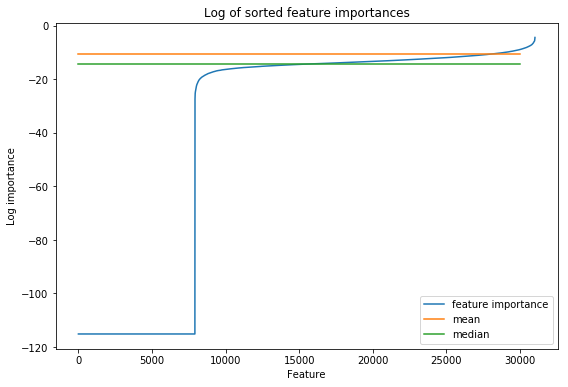

In [103]:
# take a look at all feature importances sorted
plt.figure(figsize=(9, 6))
plt.plot(np.log(np.clip(np.sort(f_is_), 1e-50, 1)), label='feature importance')
plt.plot(np.array([0, 30000]), np.ones(2) * np.log(np.mean(f_is_)), label='mean')
plt.plot(np.array([0, 30000]), np.ones(2) * np.log(np.median(f_is_)), label='median')
plt.legend()
plt.title('Log of sorted feature importances')
plt.xlabel('Feature')
plt.ylabel('Log importance');

---

In [52]:
# get sorted indices
by_imp = np.argsort(f_is_)

In [55]:
# bind the features including bigrams
v2_features = v2.get_feature_names()

In [57]:
# check size
len(v2_features)

31010

In [58]:
# look at a few
v2_features[:5]

['00a', '00a advanced', '00a analyst', '00a assistant', '00a broad']

In [59]:
# make an array
v2fa = np.array(v2_features)

In [60]:
# make sure we can index with a list of indices
v2fa[[2, 4, 6]]

array(['00a analyst', '00a broad', '00a designer'], dtype='<U34')

In [61]:
# grab top 10 features
v2fa[by_imp[-10:]]

array(['personal', 'regular', 'school', 'services', 'general', 'teacher',
       'targeted', 'disadvantaged children', 'general fund', 'employee'],
      dtype='<U34')

In [84]:
# bind and put in order
top10 = list(v2fa[by_imp[-10:]]); top10.reverse(); top10

['employee',
 'general fund',
 'disadvantaged children',
 'targeted',
 'teacher',
 'general',
 'services',
 'school',
 'regular',
 'personal']

In [66]:
# grab top 24
top24 = list(v2fa[by_imp[-24:]])

In [67]:
# let's see them
sorted(top24)

['benefits',
 'bus driver',
 'disadvantaged children',
 'duty',
 'employee',
 'fund',
 'fund teacher',
 'general',
 'general fund',
 'instruction',
 'personal',
 'professional',
 'professional instructional',
 'regular',
 'school',
 'services',
 'sub regular',
 'supplies',
 'targeted',
 'targeted assistance',
 'teacher',
 'teacher elementary',
 'time employee',
 'title']

#### How much importance for top n features?

In [95]:
# top 10
np.sum(f_is_[by_imp[-10:]])

0.09563196236676715

In [96]:
# top 100
np.sum(f_is_[by_imp[-100:]])

0.3751891268542241

In [97]:
# top 1000
np.sum(f_is_[by_imp[-1000:]])

0.8085457592573323

In [98]:
# top 10,000
np.sum(f_is_[by_imp[-10000:]])

0.9912602453015681

In [108]:
# top 15,000
np.sum(f_is_[by_imp[-15000:]])

0.9978323972247591